<a href="https://colab.research.google.com/github/uncodingthecode/Flood-Risk-Prediction/blob/main/Flood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rainfall_data = pd.read_csv('/content/drive/MyDrive/DataSets/new/rainfall_data.csv')
felevation_data = pd.read_csv('/content/drive/MyDrive/DataSets/new/elevation_data.csv')
lood_history = pd.read_csv('/content/drive/MyDrive/DataSets/new/District_FloodedArea.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**EDA 1**

Missing Values After Filling:
 SUBDIVISION    0
YEAR           0
JAN            0
FEB            0
MAR            0
APR            0
MAY            0
JUN            0
JUL            0
AUG            0
SEP            0
OCT            0
NOV            0
DEC            0
ANNUAL         0
Jan-Feb        0
Mar-May        0
Jun-Sep        0
Oct-Dec        0
dtype: int64


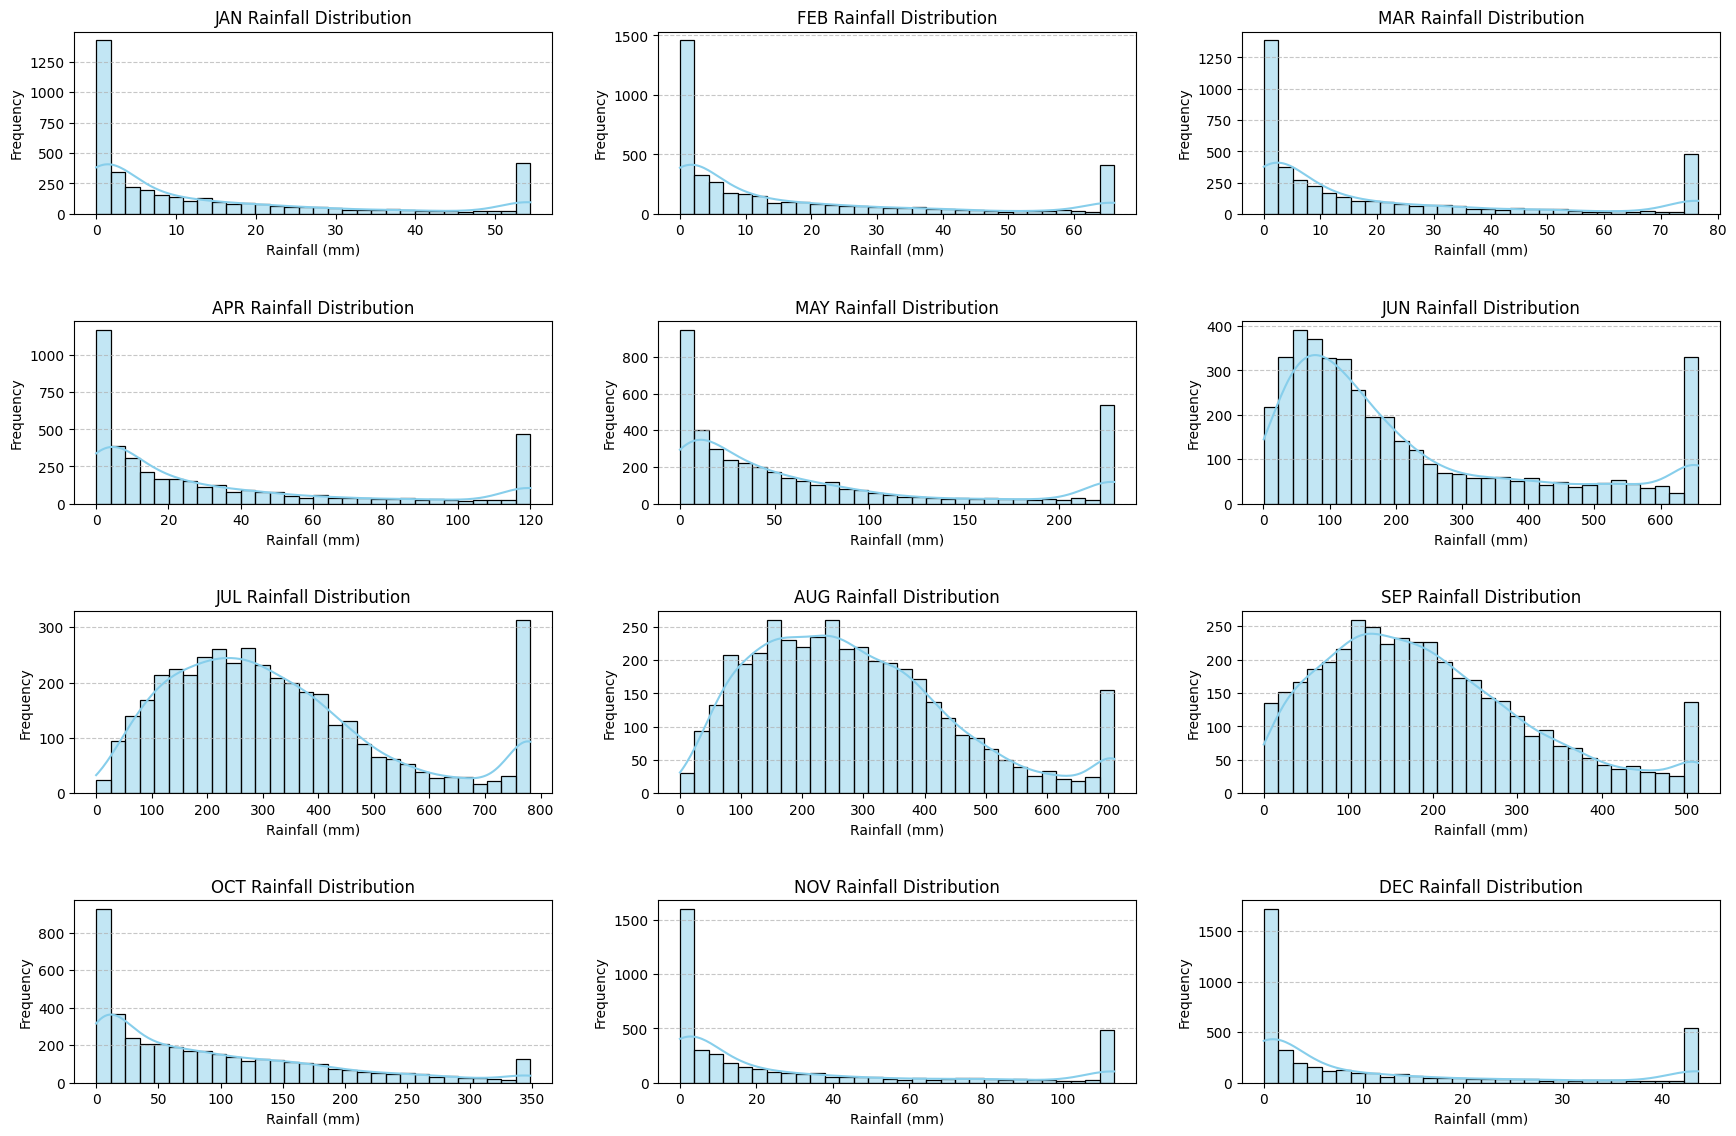

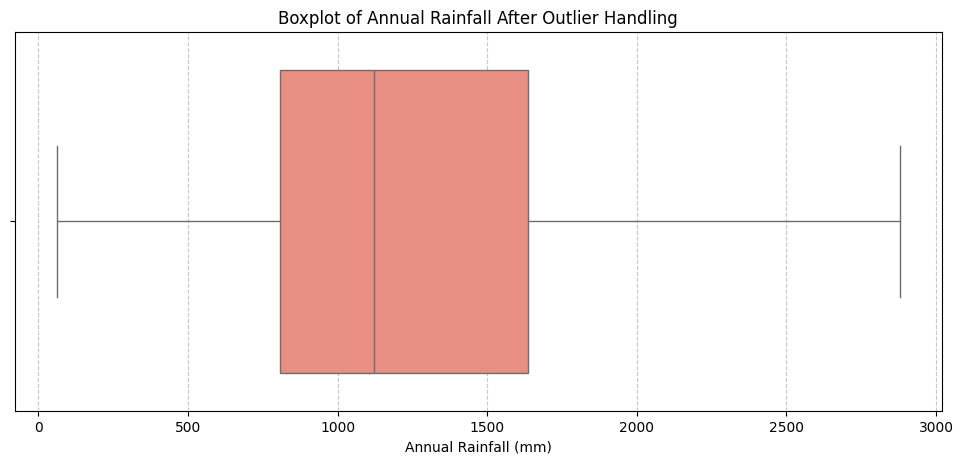

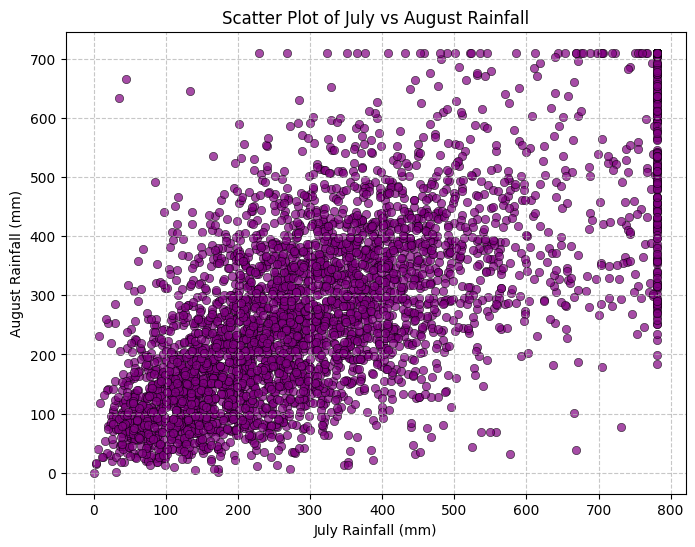

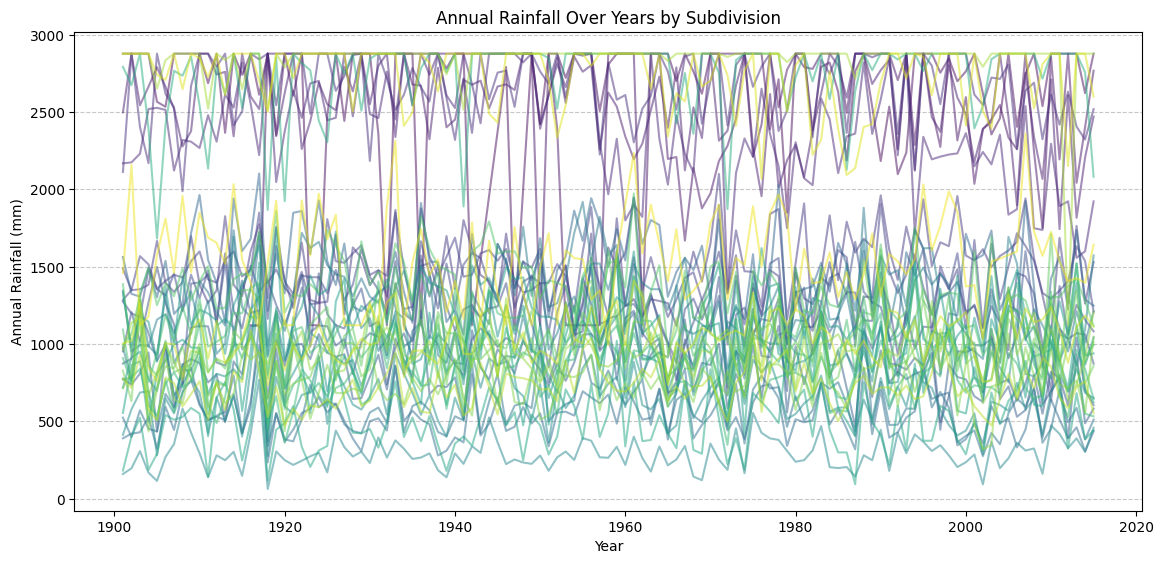

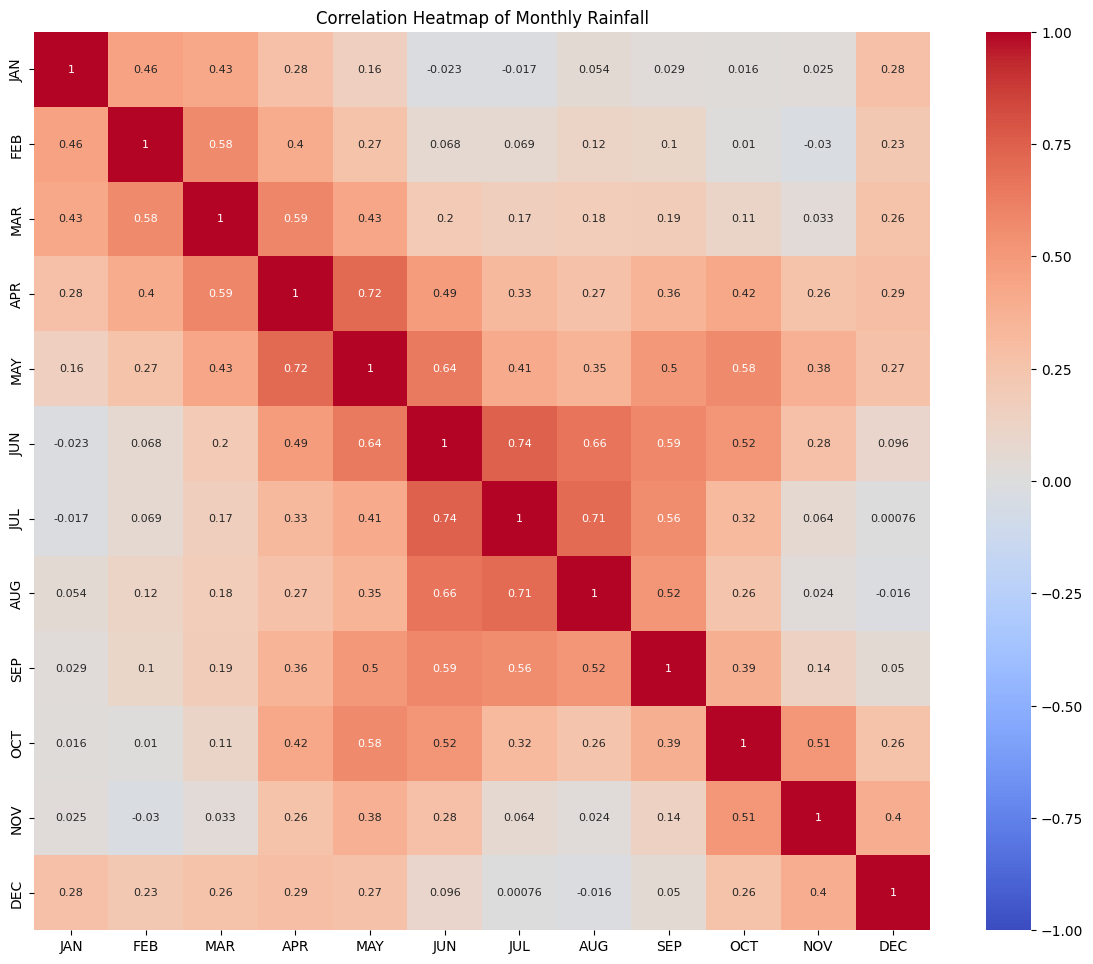

In [ ]:
# 1. Fill Missing Values with Monthly Median
rainfall_data.fillna(rainfall_data.median(numeric_only=True), inplace=True)

# 2. Outlier Handling Using IQR Method
# Define a function to handle outliers by capping them within the IQR range
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Apply the function to all monthly columns and annual rainfall
monthly_columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL']
cap_outliers(rainfall_data, monthly_columns)

# 3. Check if there are any remaining missing values
print("Missing Values After Filling:\n", rainfall_data.isnull().sum())

# 4. Distribution Plot for Each Month
plt.figure(figsize=(18, 12))
for i, month in enumerate(monthly_columns[:-1], 1):
    plt.subplot(4, 3, i)
    sns.histplot(rainfall_data[month], kde=True, bins=30, color="skyblue", edgecolor="black")
    plt.title(f'{month} Rainfall Distribution')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=3.0)
plt.show()

# 5. Boxplot for Outlier Confirmation (Annual Rainfall Example)
plt.figure(figsize=(10, 5))
sns.boxplot(x=rainfall_data['ANNUAL'], color="salmon")
plt.title("Boxplot of Annual Rainfall After Outlier Handling")
plt.xlabel("Annual Rainfall (mm)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()

# 6. Scatter Plot for Monthly Rainfall Comparison (July vs August)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='JUL', y='AUG', data=rainfall_data, color="purple", edgecolor="black", alpha=0.7)
plt.title("Scatter Plot of July vs August Rainfall")
plt.xlabel("July Rainfall (mm)")
plt.ylabel("August Rainfall (mm)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 7. Time Series Analysis of Annual Rainfall
plt.figure(figsize=(12, 6))
sns.lineplot(x='YEAR', y='ANNUAL', data=rainfall_data, hue='SUBDIVISION', legend=False, palette="viridis", alpha=0.5)
plt.title("Annual Rainfall Over Years by Subdivision")
plt.xlabel("Year")
plt.ylabel("Annual Rainfall (mm)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()

# 8. Correlation Heatmap for Monthly Rainfall
plt.figure(figsize=(12, 10))
correlation_matrix = rainfall_data[monthly_columns[:-1]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title("Correlation Heatmap of Monthly Rainfall")
plt.tight_layout(pad=2.0)
plt.show()

**EDA 2**

In [ ]:
# 1. Fill Missing Values with Median for numeric columns
elevation_data.fillna(elevation_data.median(numeric_only=True), inplace=True)

# 2. Outlier Handling using IQR Method
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Applying the function to the 'elevation' column
cap_outliers(elevation_data, ['elevation'])

# 3. Check if there are any remaining missing values
print("Missing Values in Elevation Data:\n", elevation_data.isnull().sum())

# 4. Distribution Plot for Elevation Data
plt.figure(figsize=(10, 5))
sns.histplot(elevation_data['elevation'], kde=True, bins=30, color="skyblue", edgecolor="black")
plt.title('Elevation Distribution')
plt.xlabel('Elevation (m)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()

# 5. Boxplot for Outlier Confirmation in Elevation Data
plt.figure(figsize=(10, 5))
sns.boxplot(x=elevation_data['elevation'], color="salmon")
plt.title("Boxplot of Elevation After Outlier Handling")
plt.xlabel("Elevation (m)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()

NameError: name 'elevation_data' is not defined

**EDA 3**

In [ ]:
# 1. Fill Missing Values with Median for numeric columns
flood_history.fillna(flood_history.median(numeric_only=True), inplace=True)

# 2. Outlier Handling using IQR Method
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Applying the function to relevant columns in the flooded area dataset
flooded_columns = ['Percent_Flooded_Area', 'Parmanent_Water', 'Corrected_Percent_Flooded_Area']
cap_outliers(flood_history, flooded_columns)

# 3. Check if there are any remaining missing values
print("Missing Values in Flooded Area Data:\n", flood_history.isnull().sum())

# 4. Distribution Plots for Flooded Area Data
plt.figure(figsize=(15, 5))
for i, col in enumerate(flooded_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(flood_history[col], kde=True, bins=30, color="coral", edgecolor="black")
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()

# 5. Boxplot for Outlier Confirmation (Example: Corrected Percent Flooded Area)
plt.figure(figsize=(10, 5))
sns.boxplot(x=flood_history['Corrected_Percent_Flooded_Area'], color="salmon")
plt.title("Boxplot of Corrected Percent Flooded Area After Outlier Handling")
plt.xlabel("Corrected Percent Flooded Area (%)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()

# 6. Correlation Heatmap for Flooded Area Data
plt.figure(figsize=(8, 6))
correlation_matrix_flooded = flood_history[flooded_columns].corr()
sns.heatmap(correlation_matrix_flooded, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title("Correlation Heatmap of Flooded Area Metrics")
plt.tight_layout(pad=2.0)
plt.show()

**Random Forest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

rainfall_data['SUBDIVISION'] = rainfall_data['SUBDIVISION'].str.lower()
flood_history['Dist_Name'] = flood_history['Dist_Name'].str.lower()
elevation_data.rename(columns={'District': 'Dist_Name'}, inplace=True)
elevation_data['Dist_Name'] = elevation_data['Dist_Name'].str.lower()



def match_district_names(source_series, *target_series_list, initial_threshold=80, min_threshold=50, step=10):
    # Combine all target series into a comprehensive set of unique names
    combined_targets = pd.Series(pd.concat(target_series_list).unique())

    matched_names = {}

    for name in source_series.unique():
        # Try matching with a high threshold and gradually lower it
        threshold = initial_threshold
        matched = False

        while threshold >= min_threshold and not matched:
            match_score = process.extractOne(name, combined_targets, scorer=fuzz.token_sort_ratio)

            # Check if we found a match within the current threshold
            if match_score and match_score[1] >= threshold:
                matched_names[name] = match_score[0]
                matched = True
            else:
                # Lower the threshold incrementally
                threshold -= step

        # If no match found above minimum threshold, keep original name
        if not matched:
            matched_names[name] = name

    return matched_names

# Apply fuzzy matching to standardize names in rainfall_data with broader method
rainfall_data['SUBDIVISION'] = rainfall_data['SUBDIVISION'].map(
    match_district_names(rainfall_data['SUBDIVISION'], flood_history['Dist_Name'], elevation_data['Dist_Name'])
)

# Step 4: Merge Datasets
merged_data = pd.merge(rainfall_data, flood_history, left_on='SUBDIVISION', right_on='Dist_Name', how='inner')
merged_data = pd.merge(merged_data, elevation_data, on='Dist_Name', how='left')

# Print the shape of merged_data to check for 0 rows
print("Shape of merged_data:", merged_data.shape)

# Step 5: Feature Engineering
# Create flood vulnerability score from historical data
merged_data['Flood_Vulnerability_Score'] = merged_data['Corrected_Percent_Flooded_Area'] + merged_data['Parmanent_Water']

# Create flood risk category (High, Medium, Low) based on rainfall, elevation, and vulnerability score
conditions = [
    (merged_data['ANNUAL'] > 1000) & (merged_data['elevation'] < 100) & (merged_data['Flood_Vulnerability_Score'] > 5),
    (merged_data['ANNUAL'] > 500) & (merged_data['elevation'] < 200) & (merged_data['Flood_Vulnerability_Score'] > 2),
    (merged_data['ANNUAL'] <= 500) | (merged_data['elevation'] > 200) | (merged_data['Flood_Vulnerability_Score'] <= 2)
]
choices = ['High', 'Medium', 'Low']
merged_data['Flood_Risk'] = pd.Series(pd.Categorical(np.select(conditions, choices, default='Low'), categories=choices, ordered=True))

# Step 6: Model Preparation
# Select features and target for the model
X = merged_data[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'elevation', 'Flood_Vulnerability_Score']]
y = merged_data['Flood_Risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Train Model (Random Forest Classifier for Classification)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

# Initialize label encoder
label_encoder = LabelEncoder()

label_encoder.fit(choices)

# Encode the labels in y_test and y_pred
y_test_encoded = label_encoder.transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)


# Calculate F1 Score (weighted for multiclass classification)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (weighted):", f1)

# Calculate RMSE on encoded labels
rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred_encoded))
print("RMSE:", rmse)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Define a function to calculate flood vulnerability score based on rainfall
def calculate_flood_vulnerability_score(rainfall_data):
    # Calculate the total annual rainfall
    annual_rainfall = sum(rainfall_data)

    # Set flood vulnerability thresholds
    score = 0
    for rainfall in rainfall_data:
        if rainfall > 100:  # If monthly rainfall is more than 100mm, increase score
            score += 1

    # Add additional points based on annual rainfall
    if annual_rainfall > 1000:  # If annual rainfall exceeds 1000mm, increase vulnerability
        score += 2
    elif annual_rainfall > 500:
        score += 1

    # Ensure the score is within a reasonable range, e.g., 0 to 10
    score = min(score, 10)

    return score

# Function to get user input for flood risk prediction
def get_user_input():
    print("Please enter the following values to predict flood risk:")
    place_data = {}

    # Prompt user to enter monthly rainfall values
    for month in ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']:
        place_data[month] = float(input(f"Enter the average rainfall for {month} (in mm): "))

    # Prompt for elevation and flood vulnerability score
    place_data['elevation'] = float(input("Enter the elevation (in meters): "))

    # Calculate Flood Vulnerability Score based on monthly rainfall
    place_data['Flood_Vulnerability_Score'] = calculate_flood_vulnerability_score(list(place_data.values())[:12])

    return pd.DataFrame([place_data])

# Take user input for new prediction
place_df = get_user_input()

# Make prediction based on user input
predicted_risk_category = model.predict(place_df)

# Output the prediction
print("Predicted Flood Risk based on your inputs:", predicted_risk_category[0])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import label_binarize

# Initialize label encoder for encoding the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Ensure test labels are transformed similarly

# Train the classifier (Random Forest as an example)
clf = RandomForestClassifier()
clf.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_encoded = clf.predict(X_test)

# --- Calculate Mean Absolute Error (MAE) ---
mae = mean_absolute_error(y_test_encoded, y_pred_encoded)
print("Mean Absolute Error (MAE):", mae)

# --- Calculate Variance Score ---
variance_score = r2_score(y_test_encoded, y_pred_encoded)  # For classification tasks, it's the same as R-squared
print("Variance Score (R^2):", variance_score)

# --- Calculate Training and Testing Scores ---
train_score = clf.score(X_train, y_train_encoded)  # Accuracy on training set
test_score = clf.score(X_test, y_test_encoded)  # Accuracy on test set

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix  # Import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import label_binarize
import seaborn as sns# --- Confusion Matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [ ]:
#3D scatter plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Select three features for plotting
X_train_subset = X_train[['JAN', 'elevation', 'Flood_Vulnerability_Score']]
y_train_numeric = label_encoder.transform(y_train)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Map flood risk categories to colors for visualization
colors = sns.color_palette("viridis", len(choices))
risk_colors = [colors[i] for i in y_train_numeric]

# Plot the data
scatter = ax.scatter(
    X_train_subset['JAN'],
    X_train_subset['elevation'],
    X_train_subset['Flood_Vulnerability_Score'],
    c=risk_colors,
    s=50, edgecolor='k'
)

# Labeling the axes
ax.set_xlabel("JAN Rainfall (mm)")
ax.set_ylabel("Elevation (m)")
ax.set_zlabel("Flood Vulnerability Score")

# Adding legend based on risk categories
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
ax.legend(legend_labels, choices, title="Flood Risk")

plt.title("3D Scatter Plot of Flood Risk Prediction Features")
plt.show()


In [ ]:
merged_data

In [ ]:
merged_data
merged_data.to_csv('merged_data.csv', index=False)
from google.colab import files
files.download('merged_data.csv')

**Linear Regression**

In [ ]:
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load the dataset (replace with the correct path)
df = merged_data

# Drop unnecessary categorical columns
df = df.drop(columns=['SUBDIVISION', 'YEAR', 'Dist_Name'], errors='ignore')

# Define the features and handle missing values with most frequent values
features = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL',
            'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec', 'Percent_Flooded_Area', 'Parmanent_Water', 'Latitude',
            'Longitude', 'elevation']
imputer = SimpleImputer(strategy='most_frequent')
df[features] = imputer.fit_transform(df[features])

# Define features and target variable
X = df[features]
y = df['Flood_Vulnerability_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

# Fetch real-time weather data without exception handling
def get_weather_data(api_key, latitude, longitude):
    url = f'http://api.openweathermap.org/data/2.5/weather?lat={latitude}&lon={longitude}&appid={api_key}&units=metric'
    response = requests.get(url)

    if response.status_code == 200:  # Check if the request was successful
        weather_data = response.json()

        rainfall = weather_data.get('rain', {}).get('1h', 0)  # Rainfall in the last hour, default to 0 if missing
        temperature = weather_data['main']['temp']

        return {
            'rainfall': rainfall,
            'temperature': temperature,
            'latitude': latitude,
            'longitude': longitude,
            'elevation': 10  # Default elevation value
        }
    else:
        # Return default data if request fails
        print("Failed to fetch weather data.")
        return {
            'rainfall': 0,
            'temperature': 25,  # Average temperature in Celsius
            'latitude': latitude,
            'longitude': longitude,
            'elevation': 10
        }

# Predict flood risk based on real-time weather data
def predict_flood_risk(weather_data, model):
    # Construct realistic monthly and seasonal estimates from real-time data
    monthly_rainfall = weather_data['rainfall'] * 30  # Simplified monthly estimate
    annual_rainfall = monthly_rainfall * 12  # Estimate total annual rainfall

    input_data = np.array([
        monthly_rainfall,  # JAN
        monthly_rainfall,  # FEB
        monthly_rainfall,  # MAR
        monthly_rainfall,  # APR
        monthly_rainfall,  # MAY
        monthly_rainfall,  # JUN
        monthly_rainfall,  # JUL
        monthly_rainfall,  # AUG
        monthly_rainfall,  # SEP
        monthly_rainfall,  # OCT
        monthly_rainfall,  # NOV
        monthly_rainfall,  # DEC
        annual_rainfall,   # ANNUAL
        monthly_rainfall * 2,   # Jan-Feb
        monthly_rainfall * 3,   # Mar-May
        monthly_rainfall * 4,   # Jun-Sep
        monthly_rainfall * 3,   # Oct-Dec
        weather_data['rainfall'] * 0.1,  # Simplified Percent_Flooded_Area
        0,  # Parmanent_Water placeholder
        weather_data['latitude'],
        weather_data['longitude'],
        weather_data['elevation']
    ]).reshape(1, -1)

    flood_risk_prediction = model.predict(input_data)

    # Classify flood risk based on prediction
    flood_risk = np.clip(flood_risk_prediction, 0, 10)  # Example: limit score to a range of 0-10
    print(f"Predicted Flood Risk: {flood_risk}")
    return "Flood likely" if flood_risk >= 5 else "Flood unlikely"

# Get user input for location
latitude = float(input("Enter latitude: "))
longitude = float(input("Enter longitude: "))
elevation = float(input("Enter elevation: "))
api_key = 'c8b17ec76e6b9c1c0ad51b1e79002bb6'

# Fetch real-time weather data
weather_data = get_weather_data(api_key, latitude, longitude)

# Predict flood risk
flood_risk = predict_flood_risk(weather_data, model)

#print(f"Predicted Flood Risk: {flood_risk}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Define features (X) and target (y)
X = df[features]
y = df['Flood_Vulnerability_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared (Variance Score)
variance_score = r2_score(y_test, y_pred)

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Convert continuous predictions into categorical values (Low, Medium, High)
y_true_categorical = np.clip(y_test, 0, 10)  # Clip true values to the range 0-10 (adjust as needed)
y_pred_categorical = np.clip(y_pred, 0, 10)

# Classify into bins: 0-3 = Low, 4-7 = Medium, 8-10 = High
bins = [0, 3, 7, 10]
y_true_class = np.digitize(y_true_categorical, bins=bins)
y_pred_class = np.digitize(y_pred_categorical, bins=bins)

# Calculate F1 Score for multi-class classification
f1 = f1_score(y_true_class, y_pred_class, average='weighted', labels=[1, 2, 3])

# Generate ROC curve (for multi-class)
y_test_bin = label_binarize(y_true_class, classes=[1, 2, 3])  # One-hot encoding for multi-class
y_pred_bin = label_binarize(y_pred_class, classes=[1, 2, 3])

# ROC curve for each class
fpr0, tpr0, _ = roc_curve(y_test_bin[:, 0], y_pred_bin[:, 0])  # Class 1: Low
fpr1, tpr1, _ = roc_curve(y_test_bin[:, 1], y_pred_bin[:, 1])  # Class 2: Medium
fpr2, tpr2, _ = roc_curve(y_test_bin[:, 2], y_pred_bin[:, 2])  # Class 3: High

# Calculate Macro AUC
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr0, tpr0, color='blue', label=f'Low (AUC = {roc_auc_score(y_test_bin[:, 0], y_pred_bin[:, 0]):.2f})')
plt.plot(fpr1, tpr1, color='green', label=f'Medium (AUC = {roc_auc_score(y_test_bin[:, 1], y_pred_bin[:, 1]):.2f})')
plt.plot(fpr2, tpr2, color='red', label=f'High (AUC = {roc_auc_score(y_test_bin[:, 2], y_pred_bin[:, 2]):.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

# Output the calculated metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Variance Score (R-squared): {variance_score}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"F1 Score (weighted): {f1}")
print(f"Macro AUC: {roc_auc}")


In [ ]:
# Define a sample input with hypothetical rainfall and other necessary values
sample_input_data = {
    'rainfall': 10.5,  # Hypothetical hourly rainfall data in mm
    'latitude': 26.08,  # Example latitude
    'longitude': 91.47,  # Example longitude
    'elevation': 10  # Example elevation
}

# Manually create an input for all features based on the sample input data
test_input = np.array([
    sample_input_data['rainfall'],  # JAN
    sample_input_data['rainfall'],  # FEB
    sample_input_data['rainfall'],  # MAR
    sample_input_data['rainfall'],  # APR
    sample_input_data['rainfall'],  # MAY
    sample_input_data['rainfall'],  # JUN
    sample_input_data['rainfall'],  # JUL
    sample_input_data['rainfall'],  # AUG
    sample_input_data['rainfall'],  # SEP
    sample_input_data['rainfall'],  # OCT
    sample_input_data['rainfall'],  # NOV
    sample_input_data['rainfall'],  # DEC
    sample_input_data['rainfall'] * 12,  # ANNUAL (simplified as rainfall * 12)
    0,  # Jan-Feb (placeholder value)
    0,  # Mar-May (placeholder value)
    0,  # Jun-Sep (placeholder value)
    0,  # Oct-Dec (placeholder value)
    sample_input_data['rainfall'],  # Percent_Flooded_Area (simplified)
    0,  # Parmanent_Water placeholder
    sample_input_data['latitude'],
    sample_input_data['longitude'],
    sample_input_data['elevation']
]).reshape(1, -1)

# Predict flood risk based on this sample input
predicted_flood_risk = model.predict(test_input)
print(f"Predicted Flood Risk for sample input: {predicted_flood_risk[0]}")

**MLP Model**

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset (replace with the correct path)
df = merged_data

# Drop unnecessary categorical columns
df = df.drop(columns=['SUBDIVISION', 'YEAR', 'Dist_Name'], errors='ignore')

# Define the features and handle missing values with most frequent values
features = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec', 'Percent_Flooded_Area', 'Parmanent_Water', 'Latitude', 'Longitude', 'elevation']
imputer = SimpleImputer(strategy='most_frequent')
df[features] = imputer.fit_transform(df[features])

# Define features and target variable
X = df[features]
y = df['Flood_Vulnerability_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the imputer, scaler, and model in a pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fills NaNs with the column mean
    ('scaler', StandardScaler()),                # Scales the features
    ('mlp', MLPRegressor(hidden_layer_sizes=(64, 64, 32), max_iter=500, random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on test data and evaluate the model
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

# Convert predictions and actual values to binary for F1 score calculation
threshold = 0.5
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (y_pred >= threshold).astype(int)

# Calculate and display F1 score
f1 = f1_score(y_test_binary, y_pred_binary)
print(f"F1 Score: {f1}")

# Collect input from the user for each feature
def get_user_input():
    print("Please enter the following values to predict flood risk:")
    place_data = {}

    for month in ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']:
        place_data[month] = float(input(f"Enter the average rainfall for {month} (in mm): "))

    # Prompt for seasonal and annual rainfall
    place_data['ANNUAL'] = float(input("Enter the annual rainfall (in mm): "))
    place_data['Jan-Feb'] = float(input("Enter the Jan-Feb rainfall (in mm): "))
    place_data['Mar-May'] = float(input("Enter the Mar-May rainfall (in mm): "))
    place_data['Jun-Sep'] = float(input("Enter the Jun-Sep rainfall (in mm): "))
    place_data['Oct-Dec'] = float(input("Enter the Oct-Dec rainfall (in mm): "))

    # Prompt for additional features
    place_data['Percent_Flooded_Area'] = float(input("Enter the flooded area percentage: "))
    place_data['Parmanent_Water'] = float(input("Enter the permanent water index: "))
    place_data['Latitude'] = float(input("Enter the latitude: "))
    place_data['Longitude'] = float(input("Enter the longitude: "))
    place_data['elevation'] = float(input("Enter the elevation (in meters): "))
    #1place_data['Flood_Vulnerability_Score'] = calculate_flood_vulnerability_score(list(place_data.values())[:12])

    return pd.DataFrame([place_data])

# Convert input to numpy array and reshape to 1match model input
test_input = get_user_input().values.reshape(1, -1)

# Scale and predict using the trained pipeline
test_output = pipeline.predict(test_input)

# Display the prediction result
print("Predicted Flood Risk Score:", test_output[0])
#print(place_data)

In [ ]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Explained Variance
explained_variance = explained_variance_score(y_test, y_pred)
print(f"Explained Variance: {explained_variance}")

# ROC Curve for regression (assume binary threshold of 0.5 for classification-like ROC curve)
# Set threshold, e.g., classify as "High Risk" if predicted flood risk score > 0.5
binary_y_test = (y_test >= 0.5).astype(int)  # Convert true values to binary
binary_y_pred = (y_pred >= 0.5).astype(int)  # Convert predictions to binary

fpr, tpr, thresholds = roc_curve(binary_y_test, y_pred)  # Use raw y_pred for continuous ROC
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP Regression (Threshold-Based)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define binary classification (threshold at 0.5)
y_test_binary = (y_test >= 0.5).astype(int)  # True labels as binary
y_pred_binary = (y_pred >= 0.5).astype(int)  # Predictions as binary

# Compute and display confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Risk", "High Risk"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Threshold-Based Flood Risk Prediction")
plt.show()


**Logistic Regression**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error, f1_score, mean_squared_error, explained_variance_score

# Drop rows with missing values
merged_data_cleaned = merged_data.dropna()

# Encode the target variable 'Flood_Risk' as binary (0: Low, 1: High)
merged_data_cleaned['Flood_Risk'] = merged_data_cleaned['Flood_Risk'].apply(lambda x: 1 if x == 'High' else 0)

# Check initial class distribution
print("Initial Class Distribution:\n", merged_data_cleaned['Flood_Risk'].value_counts())

# Aggregate monthly rainfall data (e.g., calculate the average of the last 3 months)
merged_data_cleaned['Avg_Monthly_Rainfall'] = merged_data_cleaned[['AUG', 'SEP', 'OCT']].mean(axis=1)

# Select features (Average Rainfall and Elevation) and target
features = merged_data_cleaned[['Avg_Monthly_Rainfall', 'elevation']]
target = merged_data_cleaned['Flood_Risk']

# Separate majority and minority classes
majority = merged_data_cleaned[merged_data_cleaned['Flood_Risk'] == 0]
minority = merged_data_cleaned[merged_data_cleaned['Flood_Risk'] == 1]

# Upsample minority class to balance the dataset
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=0)
merged_data_balanced = pd.concat([majority, minority_upsampled])

# Verify class distribution after balancing
print("Class distribution after balancing:\n", merged_data_balanced['Flood_Risk'].value_counts())

# Select features and target
features = merged_data_balanced[['Avg_Monthly_Rainfall', 'elevation']]
target = merged_data_balanced['Flood_Risk']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=0, stratify=target)

# Initialize and train logistic regression model
log_reg = LogisticRegression(class_weight="balanced", random_state=0)
log_reg.fit(X_train, y_train)

# Evaluate the model
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Predict flood risk based on user input for Rainfall and Elevation
def predict_flood_risk():
    # Prompt the user for input values (average rainfall over the last 3 months and elevation)
    avg_rainfall = float(input("Enter the average monthly rainfall (in mm) over the last 3 months: "))
    elevation = float(input("Enter the elevation of the area (in meters): "))

    # Create a DataFrame with the input values, making sure it matches the model features
    input_data = pd.DataFrame([[avg_rainfall, elevation]], columns=['Avg_Monthly_Rainfall', 'elevation'])

    # Standardize the input data (to match the scaling applied during training)
    input_data_scaled = scaler.transform(input_data)

    # Predict flood risk using the trained logistic regression model
    prediction = log_reg.predict(input_data_scaled)

    # Interpret the prediction
    risk_level = "High" if prediction[0] == 1 else "Low"

    # Display the result
    print(f"Predicted Flood Risk Level: {risk_level}")

# Call the function to predict flood risk
predict_flood_risk()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Variance Score
variance_score = explained_variance_score(y_test, y_pred)
print("Variance Score:", variance_score)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.utils import resample
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
'''
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset (replace with the correct path)
df = merged_data

# Drop unnecessary categorical columns: 'SUBDIVISION', 'YEAR', and 'Dist_Name'
df = df.drop(columns=['SUBDIVISION', 'YEAR', 'Dist_Name'], errors='ignore')

# Handle missing values for 'Percent_Flooded_Area', 'Parmanent_Water', and others with the mean or a default value
df.fillna(df.mode(), inplace=True)

# If Latitude, Longitude, and elevation columns are missing, add them with default values (for example, Mumbai)
if 'Latitude' not in df.columns:
    df['Latitude'] = 19.0760  # Default latitude for Mumbai
if 'Longitude' not in df.columns:
    df['Longitude'] = 72.8777  # Default longitude for Mumbai
if 'elevation' not in df.columns:
    df['elevation'] = 10  # Default elevation value

# Define features (independent variables) and target variable (dependent variable)
features = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL',
            'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec', 'Percent_Flooded_Area', 'Parmanent_Water', 'Latitude',
            'Longitude', 'elevation']
X = df[features]  # Features
y = df['Flood_Vulnerability_Score']  # Target

# Predict flood risk based on real-time weather data
def predict_flood_risk(weather_data, model, scaler): # Add scaler as argument
    input_data = np.array([
        weather_data['rainfall'],
        # ... (rest of the input data) ...
    ]).reshape(1, -1)

    # Scale the input_data using the same scaler used for training data
    input_data_scaled = scaler.transform(input_data) # Scale the input data

    flood_risk_prediction = model.predict(input_data_scaled)

    return flood_risk_prediction[0]


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform a train-test split (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the Neural Network model
model = Sequential()

# Add input layer (the number of nodes in this layer is the same as the number of features)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Add output layer (single neuron, since we are predicting a continuous value)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predict on the test data
y_pred = model.predict(X_test)

# Check for NaN values in y_pred and replace them with a suitable value (e.g., 0)
y_pred = np.nan_to_num(y_pred)  # Replace NaN with 0

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

# Fetch real-time weather data from OpenWeatherMap API
def get_weather_data(api_key, latitude, longitude):
    url = f'http://api.openweathermap.org/data/2.5/weather?lat={latitude}&lon={longitude}&appid={api_key}&units=metric'
    response = requests.get(url)
    weather_data = response.json()

    rainfall = weather_data.get('rain', {}).get('1h', 0)
    temperature = weather_data['main']['temp']

    return {
        'rainfall': rainfall,
        'temperature': temperature,
        'latitude': latitude,
        'longitude': longitude,
        'elevation': 10  # Default elevation value
    }

# Predict flood risk based on real-time weather data
def predict_flood_risk(weather_data, model):
    input_data = np.array([
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        weather_data['rainfall'],
        0,  # Jan-Feb
        0,  # Mar-May
        0,  # Jun-Sep
        0,  # Oct-Dec
        weather_data['rainfall'],
        0,
        weather_data['latitude'],
        weather_data['longitude'],
        weather_data['elevation']
    ]).reshape(1, -1)

    flood_risk_prediction = model.predict(input_data)

    return flood_risk_prediction[0]

# Example location for prediction
latitude = 26.2006  # Example latitude for Mumbai
longitude = 92.9376  # Example longitude for Mumbai
api_key = 'c8b17ec76e6b9c1c0ad51b1e79002bb6'

# Fetch real-time weather data
weather_data = get_weather_data(api_key, latitude, longitude)

# Predict flood risk
flood_risk = predict_flood_risk(weather_data, model)

print(f"Predicted Flood Risk: {flood_risk}")

#Aradya's Code
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = merged_data

# Drop unnecessary categorical columns
df = df.drop(columns=['SUBDIVISION', 'YEAR', 'Dist_Name'], errors='ignore')

# Handle missing values
df.fillna(df.mode(), inplace=True)

# Add missing columns with default values if needed
if 'Latitude' not in df.columns:
    df['Latitude'] = 19.0760
if 'Longitude' not in df.columns:
    df['Longitude'] = 72.8777
if 'elevation' not in df.columns:
    df['elevation'] = 10

# Define features and target variable
features = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL',
            'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec', 'Percent_Flooded_Area', 'Parmanent_Water', 'Latitude',
            'Longitude', 'elevation']
X = df[features]
y = df['Flood_Vulnerability_Score']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the neural network model using MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(64, 64, 32), max_iter=500, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")
'''

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Example: Replace these with your actual test and prediction values
# y_test is the true labels from the test set
# y_pred is the predicted labels from the model
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Flood', 'Flood'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Flood Prediction")
plt.show()